# Hazem Zaky
# Programming Exercise \#4
---

# Preamble

In [40]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive
'''
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###
'''

"\n# mount Google Drive in Google Colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# change directory using the magic command %cd\n### replace [MY PATH] below with your own path in Google Drive ###\n### %cd /content/drive/My\\ Drive/[MY PATH] ###\n"

In [41]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Machine Learning for Diagnosis of 'Senioritis'**

## Problem 1.1

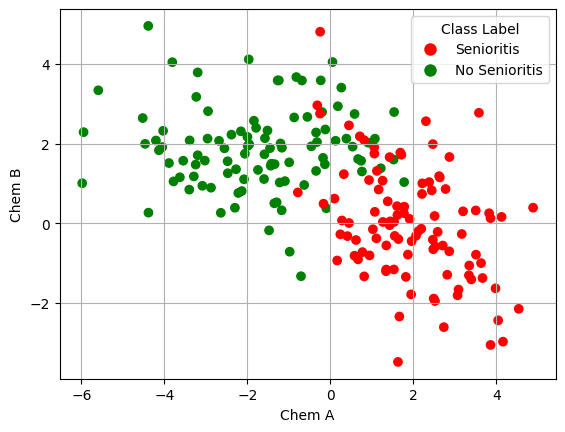

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
senioritis_train = pd.read_csv('data/SenioritisTrainingData.csv', engine="python") 

# Filter data by class label
no_senioritis_train = senioritis_train[senioritis_train['ClassLabel'] == "No Senioritis"]
has_senioritis_train = senioritis_train[senioritis_train['ClassLabel'] == "Senioritis"]

# Define colors for each class
colors = {"Senioritis": "red", "No Senioritis": "green"}

# Create the scatter plot
plt.scatter(senioritis_train["ChemA"], senioritis_train["ChemB"], 
            c=senioritis_train["ClassLabel"].map(colors), label=senioritis_train["ClassLabel"])

# Add labels and grid
plt.xlabel("Chem A")
plt.ylabel("Chem B")
plt.grid(True)

# Add legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                 for label, color in colors.items()]
plt.legend(handles=legend_labels, title="Class Label")

# Show the plot
plt.show()


## Problem 1.2

### (a)

In [ ]:
import numpy as np

class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
        self.means = None  # To store class means for prediction
        self.priors = None  # To store class priors for prediction
        self.classes = None  # To store unique class labels

    def fit(self, X, y):
        n_features = X.shape[1]
        self.classes = np.unique(y)

        # Step 1: Compute the mean of each class and the overall mean
        mean_overall = np.mean(X, axis=0)
        self.means = {label: np.mean(X[y == label], axis=0) for label in self.classes}
        self.priors = {label: (y == label).mean() for label in self.classes}

        # Step 2: Compute the within-class and between-class scatter matrices
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))

        for c in self.classes:
            X_c = X[y == c]
            mean_c = self.means[c]
            # Within-class scatter matrix
            S_W += (X_c - mean_c).T @ (X_c - mean_c)

            # Between-class scatter matrix
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            S_B += n_c * (mean_diff @ mean_diff.T)

        # Step 3: Solve the generalized eigenvalue problem for S_W^(-1) * S_B
        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)

        # Step 4: Sort eigenvectors by eigenvalues in descending order
        eigvecs = eigvecs[:, np.argsort(-eigvals.real)]
        self.linear_discriminants = eigvecs[:, :self.n_components]

    def transform(self, X):
        # Step 5: Project the data onto the linear discriminants
        return np.dot(X, self.linear_discriminants)

    def predict(self, X):
        predictions = []
        for x in X:
            discriminants = {}
            for c in self.classes:
                # Project the data point onto the linear discriminant
                projected_x = np.dot(self.linear_discriminants.T, x)
                mean_c_projected = np.dot(self.linear_discriminants.T, self.means[c])

                # Calculate the discriminant function for each class
                discriminants[c] = np.dot(projected_x, mean_c_projected) - 0.5 * np.dot(mean_c_projected, mean_c_projected) + np.log(self.priors[c])

            # Predict the class with the highest discriminant value
            predictions.append(max(discriminants, key=discriminants.get))

        return np.array(predictions)


### (b)

In [44]:
class QDA:
    def __init__(self):
        self.means = None
        self.priors = None
        self.cov_matrices = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {cls: X[y == cls].mean(axis=0) for cls in self.classes}
        self.priors = {cls: (y == cls).mean() for cls in self.classes}
        self.cov_matrices = {cls: np.cov(X[y == cls].T) for cls in self.classes}

    def predict(self, X):
        predictions = []
        for x in X:
            discriminants = {cls: -0.5 * np.log(np.linalg.det(self.cov_matrices[cls])) -
                             0.5 * (x - self.means[cls]).T @ np.linalg.inv(self.cov_matrices[cls]) @ (x - self.means[cls]) +
                             np.log(self.priors[cls]) for cls in self.classes}
            predictions.append(max(discriminants, key=discriminants.get))
        return np.array(predictions)



### (c)

In [45]:
class GaussianNB:
    def __init__(self):
        self.means = None
        self.vars = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {cls: X[y == cls].mean(axis=0) for cls in self.classes}
        self.vars = {cls: X[y == cls].var(axis=0) for cls in self.classes}
        self.priors = {cls: (y == cls).mean() for cls in self.classes}

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {cls: np.sum(-0.5 * np.log(2 * np.pi * self.vars[cls]) -
                                      ((x - self.means[cls]) ** 2) / (2 * self.vars[cls])) +
                             np.log(self.priors[cls]) for cls in self.classes}
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)


### (d)

In [46]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            # Compute distances from x to all training samples
            distances = np.linalg.norm(self.X_train - x, axis=1)
            # Find the k nearest neighbors
            k_indices = distances.argsort()[:self.k]
            k_neighbors = self.y_train[k_indices]
            # Predict the most common class among the neighbors
            predictions.append(np.bincount(k_neighbors).argmax())
        return np.array(predictions)



## Problem 1.3

### (a)

In [47]:
def evaluate_model_manual(model, X_test, y_test, description="Model"):
    # Predict the labels for the test data
    y_pred = model.predict(X_test)
    
    # Initialize confusion matrix components
    tp = 0  # True Positives
    tn = 0  # True Negatives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    # Compute confusion matrix components manually
    for true_label, predicted_label in zip(y_test, y_pred):
        if true_label == 1 and predicted_label == 1:
            tp += 1
        elif true_label == 0 and predicted_label == 0:
            tn += 1
        elif true_label == 0 and predicted_label == 1:
            fp += 1
        elif true_label == 1 and predicted_label == 0:
            fn += 1

    # Compute Metrics
    total_samples = len(y_test)
    error_rate = (fp + fn) / total_samples
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0  # False Negative Rate

    # Print Results
    print(f"--- {description} Evaluation ---")
    print(f"Empirical Probability of Error: {error_rate:.4f}")
    print(f"True Positives (TP): {tp}")
    print(f"True Positive Rate (TPR): {tpr:.4f}")
    print(f"False Positives (FP): {fp}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"True Negatives (TN): {tn}")
    print(f"True Negative Rate (TNR): {tnr:.4f}")
    print(f"False Negatives (FN): {fn}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print()

test_data = pd.read_csv('data/SenioritisTestData.csv', engine='python')
X_test = test_data[['ChemA', 'ChemB']].values  # Feature matrix
y_test = test_data['ClassLabel'].map({'No Senioritis': 0, 'Senioritis': 1}).values  # Map labels to numerical values

train_data = pd.read_csv('data/SenioritisTrainingData.csv', engine='python')
X_train = train_data[['ChemA', 'ChemB']].values  # Feature matrix
y_train = train_data['ClassLabel'].map({'No Senioritis': 0, 'Senioritis': 1}).values  # Map labels to numerical values
# Evaluate LDA
lda = LDA(n_components=1)
lda.fit(X_train, y_train)
evaluate_model_manual(lda, X_test, y_test, description="LDA")

# Evaluate QDA
qda = QDA()
qda.fit(X_train, y_train)
evaluate_model_manual(qda, X_test, y_test, description="QDA")

# Evaluate Gaussian Naïve Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
evaluate_model_manual(gnb, X_test, y_test, description="Gaussian Naïve Bayes")

knn = KNN(k=3)
knn.fit(X_train, y_train)
evaluate_model_manual(knn, X_test, y_test, description="k-Nearest Neighbors (k=3)")


ValueError: shapes (1,) and (2,) not aligned: 1 (dim 0) != 2 (dim 0)

### (b)

In [ ]:
### Your code for 1.3(b) goes here ###

### (c)

In [ ]:
### Your code for 1.3(c) goes here ###

### (d)

In [ ]:
### Your code for 1.3(d) goes here ###

### (e)

In [ ]:
### Your code for 1.3(e) goes here ###

## Problem 1.4

_[Your answer for 1.4 goes here]_

## Problem 1.5

### (a)

In [ ]:
### Your code for 1.5(a) goes here ###

### (b)

In [ ]:
### Your code for 1.5(b) goes here ###

### (c)

In [ ]:
### Your code for 1.5(c) goes here ###

### (d)

In [ ]:
### Your code for 1.5(d) goes here ###

### (e)

In [ ]:
### Your code for 1.5(e) goes here ###

## Problem 1.6


### (a)

In [ ]:
### Your code for 1.6(a) goes here ###

### (b)

_[Your answer for 1.6(b) goes here]_